# 🥇 Olympic Figure Skating: Art vs Technical Power (2006–2026)

### Who I Am & Why I picked this topic

<div style="display: flex; align-items: flex-start; gap: 20px;">

<div style="flex: 2;">

Hi, I'm **Nupur!!** just another chronically online girl who fell down a very specific internet rabbit hole.

It started with the internet's favorite alt baddie, **Alysa Liu**. She felt like a shot of espresso, electric, fearless & different. That curiosity pulled me into watching the Olympics, and suddenly I was binge-learning figure skating from YouTubers like **[Cathy](https://www.youtube.com/watch?v=6s8zNzJ-BaU)**, who patiently broke down the scoring system so it actually made sense.

Once I understood how scoring worked, I couldn't stop thinking about something fans constantly argue about:

## 🎯 The Central Question
### > **In Olympic figure skating, does technical difficulty win medals — or does artistry?**
> *Everything in this notebook is built to answer that one question.*

</div>

<div style="flex: 1;">
<img src="https://media1.tenor.com/m/2yxMp5dA4PwAAAAd/alysa-liu-gold-medal.gif" width="250"/>
</div>

</div>

---

## Before We Start: What You Need to Know

### What Is Figure Skating?

Figure skating is a sport where individuals, pairs, or teams perform choreographed routines on ice, combining athletic skill with artistic expression.
>For this project, we'll only focus on the individual performances called **Singles** format
<div style="display: flex; align-items: center; gap: 16px; margin: 8px 0 12px 0;">
    <img src="https://media1.giphy.com/media/v1.Y2lkPTc5MGI3NjExYXplbmxrNDlpY252NXFjNWwzOHlxNnNsaXIzdTZqbnAyOXNvdXNsdSZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/kILL1ObKLuwE7GvsBV/giphy.gif" width="170" style="flex-shrink: 0; border-radius: 8px;" />
    <span>
        In figure skating, athletic power and artistic quality are judged together - big jumps boost TES, while choreography and interpretation boost PCS.<br><br>
        1. <b>Athletic difficulty</b> — jumps, speed, risk<br>
        2. <b>Artistic performance</b> — skating skills, choreography, interpretation
    </span>
</div>

## > At the Olympics, both matter. The question is: **which one matters more?**

---

<div style="display: flex; gap: 48px; margin: 16px 0;">

<div style="flex: 1;">

### 🏅 Olympic Singles Format

Each skater performs **two programs**:

1. **Short Program (SP)** — fewer elements, stricter rules
2. **Free Skate (FS)** — [only the Top 24 skaters from the SP qualify to go to FS round] longer program, more elements, higher scoring potential

Final placement combines both. That's why a huge Free Skate can create comebacks, and a weak Short Program can put someone behind immediately.

</div>

<div style="flex: 1;">

### 🧮 How Scoring Works (Just the Essentials)

Each program score has three parts:

1. **TES (Technical Element Score)** — points from jumps, spins, and step sequences
2. **PCS (Program Component Score)** — points for skating quality and performance
3. **Deductions** — falls and penalties

**Total Score = TES + PCS − Deductions**
</div>
</div>

---
## Building the Dataset

I spent way too long looking for a ready-made dataset on Kaggle before accepting that it simply didn't exist. Figure skating is a niche sport, and nobody had put together a clean dataset with both TES (technical) and PCS (artistic) component scores for Olympic singles skating across multiple years. So I did what any slightly obsessed person would do — I built it myself.

The data comes straight from **[ISU](https://www.isuresults.com/results/season2526/owg2026/)** — the International Skating Union, the governing body of figure skating. They have a complete archive of competition results on their website, broken down by segment, score, and component. It's all there, it just wasn't in a CSV.

I did try web scraping first. Keyword: *tried*. It was taking longer to figure out than just... opening the pages and building the dataset manually. I'll figure out web scraping. One day. 😅

I ended up building two CSV files with different levels of granularity`[used Excel for this]`:

**1. `olympics_singles_long`** — one row per skater per segment (SP and FS separately)
`[year, gender, segement, rank, skater, nation, tss, tes, pcs, ded]`

**2. `olympics_singles_agg`** — one row per skater per Olympics, with everything aggregated
`[year, gender, final_rank, skater, nation, total_tss, sp_rank, fs_rank, tss_sp, tes_sp, pcs_sp, tss_fs,tes_fs, pcs_fs, tes_total, pcs_total, tech_dominance, medal]`

And honestly? I'm thinking of publishing this on Kaggle once the project is done — because if I had to build it from scratch, someone else probably struggled to find it too. Figure skating deserves better dataset representation. Consider this my contribution. 🛹

---

## 🔍 Loading & Validating the Data

Before any analysis, we load both CSVs and immediately run a quick audit — shapes, column names, data types, missing values, duplicate rows. Just because the data was built manually doesn't mean nothing snuck through, and these checks are what save you two hours of debugging later when a chart looks wrong and you can't figure out why.

#### 🧮 The Metric That Runs This Entire Analysis: `tech_dominance`

TES and PCS are raw scores, and raw scores shift across eras — a TES of 90 meant something very different in 2006 than in 2026 as jump difficulty, scoring standards, and judging calibration have all evolved. Comparing them directly across years would be comparing apples to oranges.

So instead of asking *"how high was the TES?"*, we ask: `**"what share of the total score came from technique?"**`
```
tech_dominance = TES / (TES + PCS)
```

It's a ratio between 0 and 1 — always relative, always era-neutral. A value of **0.53** means 53% of the score came from technical elements and 47% from artistry, regardless of whether the total was 200 or 300.

This is the spine of the analysis because our central question is `*"does technique win medals over artistry?"*` — and `tech_dominance` is literally the numerical form of that question. TES and PCS alone can't answer it: a skater with TES 80/PCS 70 wins *differently* than one with TES 100/PCS 90, even though the second has higher raw scores on both. The ratio cuts through that and captures something about *how* a skater wins, not just whether they win.

The most important check in this first cell is cross-validating this column — recomputing `tech_dominance` from raw TES and PCS and comparing it against the Excel-derived value. If they match, we proceed. If not, we fix it before touching anything else.

In [ ]:
import pandas as pd
import numpy as np

# Load data
agg_path  = "olympics_singles_agg.csv"
long_path = "olympics_singles_long.csv"

df_agg  = pd.read_csv(agg_path)
df_long = pd.read_csv(long_path)

print("Shapes")
print("agg:",  df_agg.shape)
print("long:", df_long.shape)

print("\nColumns (agg)")
print(df_agg.columns.tolist())

print("\nColumns (long)")
print(df_long.columns.tolist())

display(df_agg.head(3))
display(df_long.head(3))

def quick_audit(df, name):
    print(f"\n===== AUDIT: {name} =====")
    display(df.dtypes.to_frame("dtype"))
    display(df.isna().sum().to_frame("missing_count").sort_values("missing_count", ascending=False).head(12))
    dupes = df.duplicated().sum()
    print("Duplicate rows:", dupes)

quick_audit(df_agg,  "olympics_singles_agg")
quick_audit(df_long, "olympics_singles_long")

required_agg = ["year", "gender", "skater", "nation", "tes_total", "pcs_total", "tech_dominance", "medal"]
missing_required = [c for c in required_agg if c not in df_agg.columns]
print("\nMissing required columns in agg:", missing_required)

for col in ["gender", "skater", "nation", "medal"]:
    if col in df_agg.columns:
        df_agg[col] = df_agg[col].astype(str).str.strip()

df_agg["year"] = pd.to_numeric(df_agg["year"], errors="coerce")

tes = pd.to_numeric(df_agg["tes_total"], errors="coerce")
pcs = pd.to_numeric(df_agg["pcs_total"], errors="coerce")
td_calc     = tes / (tes + pcs)
td_existing = pd.to_numeric(df_agg["tech_dominance"], errors="coerce")
diff = (td_existing - td_calc).abs()

print("\nTech dominance check")
print("Rows where td is NaN (existing):",   td_existing.isna().sum())
print("Rows where td_calc is NaN (calc):",  td_calc.isna().sum())
print("Max absolute difference:",           np.nanmax(diff))

worst = df_agg.loc[diff.sort_values(ascending=False).head(8).index,
                   ["year", "gender", "skater", "tes_total", "pcs_total", "tech_dominance"]]
display(worst)

print("\nYears:", sorted(df_agg["year"].dropna().unique().astype(int)))
print("Genders:", df_agg["gender"].value_counts(dropna=False).head(10))
print("Medals:",  df_agg["medal"].value_counts(dropna=False))

Shapes
agg: (357, 18)
long: (646, 10)

Columns (agg)
['year', 'gender', 'final_rank', 'skater', 'nation', 'total_tss', 'sp_rank', 'fs_rank', 'tss_sp', 'tes_sp', 'pcs_sp', 'tss_fs', 'tes_fs', 'pcs_fs', 'tes_total', 'pcs_total', 'tech_dominance', 'medal']

Columns (long)
['year', 'gender', 'segment', 'rank_segment', 'skater', 'nation', 'tss', 'tes', 'pcs', 'ded']


,year,gender,final_rank,skater,nation,total_tss,sp_rank,fs_rank,tss_sp,tes_sp,pcs_sp,tss_fs,tes_fs,pcs_fs,tes_total,pcs_total,tech_dominance,medal
0,2026,M,1,SHAIDOROV Mikhail,KAZ,291.58,5,1.0,92.94,52.45,40.49,198.64,114.68,83.96,167.13,124.45,57.32%,1
1,2026,M,2,KAGIYAMA Yuma,JPN,280.06,2,6.0,103.07,56.50,46.57,176.99,92.15,85.84,148.65,132.41,52.89%,2
2,2026,M,3,SATO Shun,JPN,274.90,9,3.0,88.70,46.77,41.93,186.20,101.85,84.35,148.62,126.28,54.06%,3


,year,gender,segment,rank_segment,skater,nation,tss,tes,pcs,ded
0,2006,M,SP,1,PLUSHENKO Evgeni,RUS,90.66,49.69,40.97,0
1,2006,M,SP,2,WEIR Johnny,USA,80.00,40.99,39.01,0
2,2006,M,SP,3,LAMBIEL Stephane,SUI,79.04,40.61,38.43,0



===== AUDIT: olympics_singles_agg =====


,dtype
year,int64
gender,str
final_rank,str
skater,str
nation,str
total_tss,float64
sp_rank,int64
fs_rank,float64
tss_sp,float64
tes_sp,float64


,missing_count
fs_rank,6
year,0
gender,0
final_rank,0
nation,0
skater,0
total_tss,0
sp_rank,0
tss_sp,0
tes_sp,0


Duplicate rows: 0

===== AUDIT: olympics_singles_long =====


,dtype
year,int64
gender,str
segment,str
rank_segment,str
skater,str
nation,str
tss,float64
tes,float64
pcs,float64
ded,int64


,missing_count
year,0
gender,0
segment,0
rank_segment,0
skater,0
nation,0
tss,0
tes,0
pcs,0
ded,0


Duplicate rows: 0

Missing required columns in agg: []

Tech dominance check
Rows where td is NaN (existing): 357
Rows where td_calc is NaN (calc): 3
Max absolute difference: nan


C:\Users\gnupu\AppData\Local\Temp\ipykernel_28360\2658600515.py:53: RuntimeWarning: All-NaN axis encountered
  print("Max absolute difference:",           np.nanmax(diff))


,year,gender,skater,tes_total,pcs_total,tech_dominance
0,2026,M,SHAIDOROV Mikhail,167.13,124.45,57.32%
1,2026,M,KAGIYAMA Yuma,148.65,132.41,52.89%
2,2026,M,SATO Shun,148.62,126.28,54.06%
3,2026,M,CHA Junhwan,145.24,129.68,52.83%
4,2026,M,GOGOLEV Stephen,151.45,122.33,55.32%
5,2026,M,GUMENNIK Petr,152.27,118.94,56.14%
6,2026,M,SIAO HIM FA Adam,142.24,128.03,52.63%
7,2026,M,MALININ Ilia,138.96,127.53,52.14%



Years: [np.int64(2006), np.int64(2010), np.int64(2014), np.int64(2018), np.int64(2022), np.int64(2026)]
Genders: gender
M    179
W    178
Name: count, dtype: int64
Medals: medal
0    321
1     12
2     12
3     12
Name: count, dtype: int64


---
## 🧹 Cleaning & Building the Working Dataset

The second cell takes the raw `df_agg` and builds `df` — the clean, canonical copy that every single analysis cell will use from here on.

Five things happen here:

1. **Text fields stripped** — skater names and nations can have sneaky leading/trailing spaces from Excel. Gone.
2. **Gender mapped** — raw values are `M` and `W`. We map them to `Men` and `Women` so every chart label is human-readable without extra work.
3. **Score columns forced to numeric** — pandas sometimes reads numbers as strings depending on how Excel exported them. We force every score column to float, turning any bad values into `NaN` rather than letting them silently break calculations.
4. **Medal labels created** — the raw `medal` column is `1`, `2`, `3`. We map that to `Gold`, `Silver`, `Bronze` and store it as `medal_label` so we can filter and label intuitively.
5. **Tech dominance recomputed** — rather than trusting the Excel column, we derive `tech_dominance`, `tech_dom_sp`, and `tech_dom_fs` directly from the score components. This guarantees consistency across the entire notebook.

> From this point forward, `df` is the only dataframe used for analysis.

In [1]:
import pandas as pd
import numpy as np

agg_path  = "olympics_singles_agg.csv"
long_path = "olympics_singles_long.csv"

df_agg  = pd.read_csv(agg_path)
df_long = pd.read_csv(long_path)

df = df_agg.copy()

for col in ["skater", "nation"]:
    df[col] = df[col].astype(str).str.strip()

df["gender"] = df["gender"].astype(str).str.strip().map({"M": "Men", "W": "Women"})

numeric_cols = ["year", "tes_total", "pcs_total", "tes_sp", "pcs_sp", "tes_fs", "pcs_fs"]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df["medal"] = pd.to_numeric(df["medal"], errors="coerce")
df["medal_label"] = df["medal"].map({1: "Gold", 2: "Silver", 3: "Bronze"})

df["tech_dominance"] = df["tes_total"] / (df["tes_total"] + df["pcs_total"])
df["tech_dom_sp"]    = df["tes_sp"]    / (df["tes_sp"]    + df["pcs_sp"])
df["tech_dom_fs"]    = df["tes_fs"]    / (df["tes_fs"]    + df["pcs_fs"])

print("Cleaned dataset shape:", df.shape)
print("\nMedal breakdown:")
print(df["medal_label"].value_counts(dropna=False))
print("\nDominance range:")
print("Min:", round(df["tech_dominance"].min(), 3))
print("Max:", round(df["tech_dominance"].max(), 3))
display(df.head(3))

Cleaned dataset shape: (357, 21)

Medal breakdown:
medal_label
NaN       321
Gold       12
Silver     12
Bronze     12
Name: count, dtype: int64

Dominance range:
Min: 0.385
Max: 0.59


,year,gender,final_rank,skater,nation,total_tss,sp_rank,fs_rank,tss_sp,tes_sp,...,tss_fs,tes_fs,pcs_fs,tes_total,pcs_total,tech_dominance,medal,medal_label,tech_dom_sp,tech_dom_fs
0,2026,Men,1,SHAIDOROV Mikhail,KAZ,291.58,5,1.0,92.94,52.45,...,198.64,114.68,83.96,167.13,124.45,0.573187,1,Gold,0.564343,0.577326
1,2026,Men,2,KAGIYAMA Yuma,JPN,280.06,2,6.0,103.07,56.50,...,176.99,92.15,85.84,148.65,132.41,0.528891,2,Silver,0.548171,0.517726
2,2026,Men,3,SATO Shun,JPN,274.90,9,3.0,88.70,46.77,...,186.20,101.85,84.35,148.62,126.28,0.540633,3,Bronze,0.527283,0.546992


---

# 🎬 Act 1 — The Arena

Before we argue about what wins, let's look at the battlefield first.

Here's every single Olympic singles performance since 2006 — all 288 of them. Each dot is one skater, one Games.

- **Right** = more technical dominance
- **Up** = higher total score
- **Gold dots** = champions

Take it in. Where do champions live?

In [2]:
import plotly.graph_objects as go

GOLD_COLOR  = '#e8a020'
GREY_COLOR  = '#b0bec5'
BG_COLOR    = '#fafafa'
SPINE_COLOR = '#2c2c3a'

df_plot   = df[df['total_tss'] > 50].copy()
non_medal = df_plot[df_plot['medal_label'].isna()]
gold      = df_plot[df_plot['medal_label'] == 'Gold']

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=non_medal['tech_dominance'],
    y=non_medal['total_tss'],
    mode='markers',
    name='All Skaters',
    marker=dict(color=GREY_COLOR, size=6, opacity=0.35),
    hovertemplate=(
        '<b>%{customdata[0]}</b><br>'
        'Year: %{customdata[1]}<br>'
        'Tech Dominance: %{x:.1%}<br>'
        'Total Score: %{y:.2f}'
        '<extra></extra>'
    ),
    customdata=non_medal[['skater', 'year']].values
))

fig.add_trace(go.Scatter(
    x=gold['tech_dominance'],
    y=gold['total_tss'],
    mode='markers',
    name='Gold Medalists',
    marker=dict(color=GOLD_COLOR, size=13, opacity=0.95,
                line=dict(color=SPINE_COLOR, width=1)),
    hovertemplate=(
        '<b>🥇 %{customdata[0]}</b><br>'
        'Year: %{customdata[1]}<br>'
        'Tech Dominance: %{x:.1%}<br>'
        'Total Score: %{y:.2f}'
        '<extra></extra>'
    ),
    customdata=gold[['skater', 'year']].values
))

fig.add_vline(x=0.50, line_dash='dash', line_color='#9e9e9e', line_width=1.5,
              annotation_text='← balance →', annotation_font_color='#9e9e9e',
              annotation_position='bottom right')

fig.update_layout(
    title=dict(text='Every Performance Since 2006 — Champions Live on the Right Side',
               font=dict(size=15, color=SPINE_COLOR), x=0.5, xanchor='center'),
    xaxis=dict(title='Technical Dominance  (TES share of total score)',
               range=[0.43, 0.60], gridcolor='#e8e8ee',
               linecolor=SPINE_COLOR, ticks='outside'),
    yaxis=dict(title='Total Score', gridcolor='#e8e8ee',
               linecolor=SPINE_COLOR, ticks='outside'),
    plot_bgcolor=BG_COLOR, paper_bgcolor=BG_COLOR,
    legend=dict(font=dict(size=10), bordercolor=SPINE_COLOR, borderwidth=1),
    hoverlabel=dict(bgcolor='white', bordercolor=SPINE_COLOR, font_size=12),
    width=860, height=560
)
fig.show()

> Champions don't just score high. They score high **and** they lean technical.
>
> You can find high-scoring skaters across the whole spectrum —
> but **gold medalists cluster toward the right** of the balance line.
>
> Artistry keeps you in the game. Technical difficulty wins it.

---

## Act 2 — The Sport Evolves

Has technical dominance always predicted gold? Or has Olympic skating quietly shifted over time — with every new quad jump changing what it takes to win?

*If the sport is getting more technical over time, the central question has a time dimension too.*

Let's track gold medalists year by year, for both men and women.

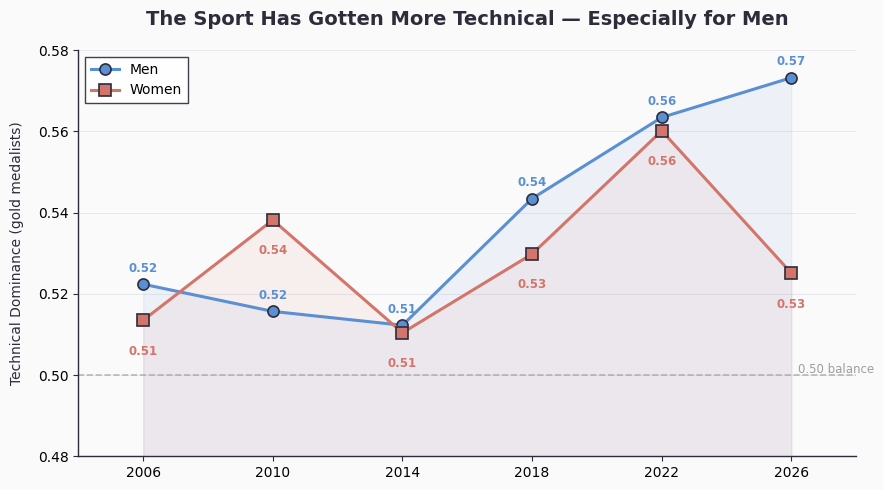

In [3]:
import matplotlib.pyplot as plt

SPINE_COLOR = '#2c2c3a'
GRID_COLOR  = '#e8e8ee'
BG_COLOR    = '#fafafa'
TEXT_COLOR  = '#2c2c3a'
MEN_COLOR   = '#5b8fd4'
WOMEN_COLOR = '#d4756b'

gold  = df[df['medal_label'] == 'Gold'].copy()
trend = gold.groupby(['year', 'gender'])['tech_dominance'].mean().reset_index()
men   = trend[trend['gender'] == 'Men'].sort_values('year')
women = trend[trend['gender'] == 'Women'].sort_values('year')

fig, ax = plt.subplots(figsize=(9, 5))
fig.patch.set_facecolor(BG_COLOR)
ax.set_facecolor(BG_COLOR)

ax.plot(men['year'],   men['tech_dominance'],
        marker='o', linewidth=2.2, markersize=8,
        color=MEN_COLOR, markeredgecolor=SPINE_COLOR, markeredgewidth=1.2, label='Men')
ax.plot(women['year'], women['tech_dominance'],
        marker='s', linewidth=2.2, markersize=8,
        color=WOMEN_COLOR, markeredgecolor=SPINE_COLOR, markeredgewidth=1.2, label='Women')

ax.fill_between(men['year'],   men['tech_dominance'],   0.48, alpha=0.08, color=MEN_COLOR)
ax.fill_between(women['year'], women['tech_dominance'], 0.48, alpha=0.08, color=WOMEN_COLOR)

for _, row in men.iterrows():
    ax.text(row['year'], row['tech_dominance'] + 0.003, f'{row["tech_dominance"]:.2f}',
            ha='center', fontsize=8.5, color=MEN_COLOR, fontweight='bold')
for _, row in women.iterrows():
    ax.text(row['year'], row['tech_dominance'] - 0.006, f'{row["tech_dominance"]:.2f}',
            ha='center', fontsize=8.5, color=WOMEN_COLOR, fontweight='bold', va='top')

ax.axhline(0.50, linestyle='--', color='#9e9e9e', alpha=0.7, linewidth=1.2)
ax.text(2026.2, 0.5005, '0.50 balance', fontsize=8.5, color='#9e9e9e')

ax.set_xlim(2004, 2028)
ax.set_ylim(0.48, 0.58)
ax.set_xticks([2006, 2010, 2014, 2018, 2022, 2026])
ax.set_ylabel('Technical Dominance (gold medalists)', fontsize=10, color=TEXT_COLOR, labelpad=10)
ax.set_title('The Sport Has Gotten More Technical — Especially for Men',
             fontsize=14, fontweight='bold', pad=18, color=TEXT_COLOR)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['bottom', 'left']:
    ax.spines[spine].set_color(SPINE_COLOR)
    ax.spines[spine].set_linewidth(1)

ax.tick_params(axis='both', labelsize=10, color=SPINE_COLOR)
ax.yaxis.grid(True, color=GRID_COLOR, linewidth=0.8, zorder=0)
ax.set_axisbelow(True)
ax.legend(fontsize=10, framealpha=0.9, loc='upper left',
          edgecolor=SPINE_COLOR, fancybox=False)
plt.tight_layout()
plt.show()

> Men's skating shows a **clear upward trend** — each Olympic cycle demands more technical difficulty.
>
> Women's skating is more volatile. The quad jump revolution hit men first,
> and women's programs have been catching up in more recent cycles.
>
> **For men, technical dominance has been pulling away from the 0.50 balance line since 2010.
> For women, it's more contested — which means artistry still plays a stronger role in women's gold.**
> That gender difference will matter in the next act.

---

## 🧠 Act 3 — When does artistry actually decide medals?

The evolution chart showed us the trend. Now we go deeper.

**The central question has a hidden nuance:** if technical scores are close, does artistry become the tiebreaker? And does that happen more for women than men — because women's technical gaps are smaller?

The hypothesis: **PCS only swings outcomes when the TES gap is razor thin.** When a skater dominates technically, artistic marks barely matter. But in tight technical battles, the judges' artistic impression becomes the deciding vote.

*This is also where the gender insight from Act 2 lands: women's closer technical scores mean PCS plays a bigger swing role in women's results than men's.*

To test this, we measure two gaps between Gold and Silver for every Olympics event:
- **TES gap** — who led technically, and by how much
- **PCS gap** — who led artistically, and by how much

---

### Setup

In [4]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

df_agg = pd.read_csv('olympics_singles_agg.csv')

df_agg['tech_dominance'] = (
    df_agg['tech_dominance']
    .astype(str).str.replace('%', '', regex=False).str.strip()
    .pipe(pd.to_numeric, errors='coerce')
)
if df_agg['tech_dominance'].dropna().mean() > 1:
    df_agg['tech_dominance'] = df_agg['tech_dominance'] / 100

df_agg['nation'] = df_agg['nation'].astype(str).str.strip()
df_agg['gender'] = df_agg['gender'].astype(str).str.strip()

GOLD_COLOR   = '#e8a020'
SILVER_COLOR = '#b0bec5'
MEN_COLOR    = '#5b8cde'
WOMEN_COLOR  = '#e8607a'
BG_COLOR     = '#fafafa'
SPINE_COLOR  = '#2c2c3a'

gold   = df_agg[df_agg['medal'] == 1][['year','gender','skater','tes_total','pcs_total','total_tss']].copy()
silver = df_agg[df_agg['medal'] == 2][['year','gender','skater','tes_total','pcs_total','total_tss']].copy()

gaps = gold.merge(silver, on=['year','gender'], suffixes=('_gold','_silver'))
gaps['tes_gap']   = gaps['tes_total_gold']  - gaps['tes_total_silver']
gaps['pcs_gap']   = gaps['pcs_total_gold']  - gaps['pcs_total_silver']
gaps['total_gap'] = gaps['total_tss_gold']  - gaps['total_tss_silver']
gaps['label']     = gaps['year'].astype(str) + ' ' + gaps['gender']



### Visual 1 — The Gap Map
*Each dot is one Olympics event. Where does it fall?*

| Quadrant | Meaning |
|---|---|
| Top-right | Gold dominated **both** technically and artistically |
| Bottom-right | Technical dominance alone carried the gold |
| Top-left | 🚨 Artistry won it — Gold trailed on TES but led on PCS |
| Bottom-left | Silver was better on both — a true upset |

In [5]:
fig1 = go.Figure()

for gender, color, symbol in [('M', MEN_COLOR, 'circle'), ('W', WOMEN_COLOR, 'diamond')]:
    sub = gaps[gaps['gender'] == gender]
    fig1.add_trace(go.Scatter(
        x=sub['tes_gap'], y=sub['pcs_gap'],
        mode='markers+text',
        name='Men' if gender == 'M' else 'Women',
        marker=dict(color=color, size=13, opacity=0.85,
                    line=dict(color=SPINE_COLOR, width=0.8), symbol=symbol),
        text=sub['label'], textposition='top center',
        textfont=dict(size=8.5, color=SPINE_COLOR),
        customdata=sub[['skater_gold', 'skater_silver']].values,
        hovertemplate=(
            '<b>%{text}</b><br>'
            '🥇 %{customdata[0]}<br>'
            '🥈 %{customdata[1]}<br>'
            'TES Gap: %{x:+.2f}<br>'
            'PCS Gap: %{y:+.2f}'
            '<extra></extra>'
        )
    ))

fig1.add_hline(y=0, line_dash='dash', line_color='#9e9e9e', line_width=1)
fig1.add_vline(x=0, line_dash='dash', line_color='#9e9e9e', line_width=1)

fig1.add_annotation(x=gaps['tes_gap'].max()*0.85, y=gaps['pcs_gap'].max()*0.85,
    text='Technical + Artistic<br>dominance', showarrow=False,
    font=dict(size=9, color='#9e9e9e'), align='center')
fig1.add_annotation(x=gaps['tes_gap'].min()*0.75, y=gaps['pcs_gap'].max()*0.85,
    text='Artistry won it', showarrow=False,
    font=dict(size=9, color='#e8607a'), align='center')

fig1.update_layout(
    title=dict(
        text='Biggest Discovery— TES vs PCS Gap (Gold − Silver)<br>'
             '<sup>Positive = Gold led that dimension</sup>',
        font=dict(size=15, color=SPINE_COLOR), x=0.5, xanchor='center'),
    xaxis=dict(title='TES Gap (Gold − Silver)', gridcolor='#e8e8ee',
               linecolor=SPINE_COLOR, zerolinecolor='#ccc'),
    yaxis=dict(title='PCS Gap (Gold − Silver)', gridcolor='#e8e8ee',
               linecolor=SPINE_COLOR, zerolinecolor='#ccc'),
    plot_bgcolor=BG_COLOR, paper_bgcolor=BG_COLOR,
    legend=dict(bordercolor=SPINE_COLOR, borderwidth=1),
    hoverlabel=dict(bgcolor='white', bordercolor=SPINE_COLOR, font_size=12),
    width=820, height=560
)
fig1.show()



### Visual 2 — What Drove the Winning Margin?
*For each event, what % of the total score gap came from TES vs PCS?*

When TES drives 80%+ of the margin, the technical skater simply ran away with it. When PCS drives 50%+, artistry was the deciding force — and those tend to be the most controversial results in figure skating history.

In [6]:
gaps['tes_pct']     = (gaps['tes_gap'] / gaps['total_gap'] * 100).round(1)
gaps['pcs_pct']     = (gaps['pcs_gap'] / gaps['total_gap'] * 100).round(1)
gaps['label_short'] = gaps['year'].astype(str) + ' ' + gaps['gender']
gaps = gaps.sort_values(['year','gender'])

fig2 = go.Figure()

fig2.add_trace(go.Bar(
    name='TES share of margin', x=gaps['label_short'], y=gaps['tes_pct'],
    marker_color=GOLD_COLOR,
    hovertemplate='<b>%{x}</b><br>TES drove %{y:.1f}% of margin<extra></extra>'
))
fig2.add_trace(go.Bar(
    name='PCS share of margin', x=gaps['label_short'], y=gaps['pcs_pct'],
    marker_color=SILVER_COLOR,
    hovertemplate='<b>%{x}</b><br>PCS drove %{y:.1f}% of margin<extra></extra>'
))

fig2.add_hline(y=50, line_dash='dot', line_color='#9e9e9e', line_width=1.2,
               annotation_text='50 / 50 split', annotation_font_color='#9e9e9e',
               annotation_position='top right')

fig2.update_layout(
    barmode='group',
    title=dict(text='What Drove the Winning Margin? TES vs PCS per Olympics Event',
               font=dict(size=14, color=SPINE_COLOR), x=0.5, xanchor='center'),
    xaxis=dict(title='Event', linecolor=SPINE_COLOR, tickangle=-35),
    yaxis=dict(title='% of Total Score Gap', gridcolor='#e8e8ee', linecolor=SPINE_COLOR),
    plot_bgcolor=BG_COLOR, paper_bgcolor=BG_COLOR,
    legend=dict(bordercolor=SPINE_COLOR, borderwidth=1),
    hoverlabel=dict(bgcolor='white', bordercolor=SPINE_COLOR, font_size=12),
    width=920, height=520
)
fig2.show()



> *PCS swings outcomes only when the TES gap is small.*
> When technical scores diverge significantly, artistic marks tend to follow — judges reward the same skater on both dimensions. But in tight technical contests, PCS becomes the swing vote.



### 🤔 Wait — Why Are Some PCS Bars Negative?

**A negative PCS bar means the Silver skater was actually *more artistic* than the Gold winner.**

The person who stood on the top step of the podium was *not* the most artistic skater that day. They won purely on technical firepower.

| | TES | PCS | Total |
|---|---|---|---|
| 🥇 Gold skater | 80 | 70 | **150** |
| 🥈 Silver skater | 65 | 78 | 143 |

The TES gap is **+15** in Gold's favour, but the PCS gap is **−8** — Silver was more artistic. Gold still won because the technical lead was larger than the artistic deficit.

> 🚨 **Ahaaa:** In events like **2018 W** and **2026 W**, the Gold medalist was arguably the *less artistic* skater on the ice. They won because their jumps were simply too dominant to overcome.
>
> **And this happens more in women's events** — because women's TES gaps are smaller, PCS gets to play a bigger role. For men, when someone pulls ahead technically, it's usually decisive. For women, the artistry scores are doing more work in the final outcome.

---

## 🎬 Act 4 — Segment Drama
### *Is the Short Program a filter, and the Free Skate the verdict?*

Figure skating has two acts within the act. The **Short Program** — tight, controlled, every element mandatory. The **Free Skate** — longer, freer, where champions either confirm their throne or lose it.

**Does your SP rank seal your fate, or does the FS rewrite the story?**

If SP strongly predicts the final podium, the competition is essentially decided in the first segment. If FS is the stronger predictor, the Short Program is merely a filter and the real drama lives in the second half.

*And underneath it all — does the segment that rewards technical risk matter more than the one that rewards artistry?*





In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

df_agg = pd.read_csv('olympics_singles_agg.csv')

df_agg['tech_dominance'] = (
    df_agg['tech_dominance']
    .astype(str).str.replace('%', '', regex=False).str.strip()
    .pipe(pd.to_numeric, errors='coerce')
)
if df_agg['tech_dominance'].dropna().mean() > 1:
    df_agg['tech_dominance'] = df_agg['tech_dominance'] / 100

df_agg['nation'] = df_agg['nation'].astype(str).str.strip()

BG_COLOR    = '#fafafa'
SPINE_COLOR = '#2c2c3a'
MEN_COLOR   = '#5b8cde'
WOMEN_COLOR = '#e8607a'
GOLD_COLOR  = '#e8a020'

### Visual 1 — Who Rose and Who Fell Between SP and FS?
*Each bar is a medalist. Positive = improved their rank in the Free Skate. Negative = dropped. The bigger the bar, the more dramatic the swing.*

In [8]:
medalists_div = df_agg[df_agg['medal'].isin([1,2,3])].copy()
medalists_div['sp_rank']    = pd.to_numeric(medalists_div['sp_rank'],    errors='coerce')
medalists_div['fs_rank']    = pd.to_numeric(medalists_div['fs_rank'],    errors='coerce')
medalists_div['final_rank'] = pd.to_numeric(medalists_div['final_rank'], errors='coerce')
medalists_div = medalists_div.dropna(subset=['sp_rank','fs_rank','final_rank'])

medalists_div['rank_change'] = medalists_div['sp_rank'] - medalists_div['fs_rank']
medalists_div['label'] = (medalists_div['skater'].str.split().str[0] +
                          " '" + medalists_div['year'].astype(str).str[-2:])
medalists_div = medalists_div.sort_values('rank_change')

color_map  = {1: '#e8a020', 2: '#b0bec5', 3: '#cd7f32'}
medal_name = {1: 'Gold', 2: 'Silver', 3: 'Bronze'}

fig_div = go.Figure()
for medal in [1, 2, 3]:
    sub = medalists_div[medalists_div['medal'] == medal]
    fig_div.add_trace(go.Bar(
        x=sub['rank_change'], y=sub['label'], orientation='h',
        name=medal_name[medal], marker_color=color_map[medal],
        hovertemplate=(
            '<b>%{y}</b><br>'
            'SP Rank: %{customdata[0]:.0f}<br>'
            'FS Rank: %{customdata[1]:.0f}<br>'
            'Change: %{x:+.0f} places<extra></extra>'
        ),
        customdata=sub[['sp_rank','fs_rank']].values
    ))

fig_div.add_vline(x=0, line_color=SPINE_COLOR, line_width=1.5)
fig_div.update_layout(
    title=dict(
        text='Did Medalists Rise or Fall in the Free Skate?<br>'
             '<sup>Positive = improved rank in FS vs SP  |  Negative = dropped</sup>',
        font=dict(size=14, color=SPINE_COLOR), x=0.5, xanchor='center'),
    xaxis=dict(title='Rank Change SP → FS  (+ = climbed, − = dropped)',
               gridcolor='#e8e8ee', linecolor=SPINE_COLOR, zeroline=False),
    yaxis=dict(title='', linecolor=SPINE_COLOR, tickfont=dict(size=9)),
    barmode='relative',
    plot_bgcolor=BG_COLOR, paper_bgcolor=BG_COLOR,
    legend=dict(bordercolor=SPINE_COLOR, borderwidth=1, title='Medal'),
    hoverlabel=dict(bgcolor='white', bordercolor=SPINE_COLOR, font_size=12),
    width=820, height=620
)
fig_div.show()

### Visual 2 — How SP Positions Flow Into Final Positions
*Each ribbon shows the path from Short Program rank to Final rank for all medalists. Wider ribbon = more skaters took that path. The crossing ribbons are where the drama lives.*

In [9]:
medalists_s = df_agg[df_agg['medal'].isin([1,2,3])].copy()
medalists_s['sp_rank']    = pd.to_numeric(medalists_s['sp_rank'],    errors='coerce')
medalists_s['fs_rank']    = pd.to_numeric(medalists_s['fs_rank'],    errors='coerce')
medalists_s['final_rank'] = pd.to_numeric(medalists_s['final_rank'], errors='coerce')
medalists_s = medalists_s.dropna(subset=['sp_rank','fs_rank','final_rank'])

medalists_s['sp_rank']    = medalists_s['sp_rank'].clip(upper=10).astype(int)
medalists_s['fs_rank']    = medalists_s['fs_rank'].clip(upper=10).astype(int)
medalists_s['final_rank'] = medalists_s['final_rank'].clip(upper=3).astype(int)

medalists_s['short_name'] = (
    medalists_s['skater'].str.split().str[0].str.title() +
    " '" + medalists_s['year'].astype(str).str[-2:]
)

node_labels = (
    [f'SP {r}' for r in range(1,11)] +
    [f'FS {r}' for r in range(1,11)] +
    ['🥇 Gold', '🥈 Silver', '🥉 Bronze']
)

medal_colors = {1: '#e8a020', 2: '#b0bec5', 3: '#cd7f32'}
node_colors  = ['#5b8cde']*10 + ['#7ec8a0']*10 + [medal_colors[1], medal_colors[2], medal_colors[3]]

sources, targets, values, link_colors, link_labels = [], [], [], [], []

sp_to_fs = medalists_s.groupby(['sp_rank','fs_rank'])['short_name'].apply(list).reset_index()
for _, row in sp_to_fs.iterrows():
    sources.append(int(row['sp_rank']) - 1)
    targets.append(10 + int(row['fs_rank']) - 1)
    values.append(len(row['short_name']))
    link_colors.append('rgba(91,140,222,0.25)')
    link_labels.append(f"SP {int(row['sp_rank'])} → FS {int(row['fs_rank'])}<br>" + '<br>'.join(row['short_name']))

fs_to_final = medalists_s.groupby(['fs_rank','final_rank'])['short_name'].apply(list).reset_index()
for _, row in fs_to_final.iterrows():
    c = medal_colors[int(row['final_rank'])]
    r,g,b = int(c[1:3],16), int(c[3:5],16), int(c[5:7],16)
    sources.append(10 + int(row['fs_rank']) - 1)
    targets.append(20 + int(row['final_rank']) - 1)
    values.append(len(row['short_name']))
    link_colors.append(f'rgba({r},{g},{b},0.35)')
    link_labels.append(f"FS {int(row['fs_rank'])} → {node_labels[20+int(row['final_rank'])-1]}<br>" + '<br>'.join(row['short_name']))

fig_sankey = go.Figure(go.Sankey(
    arrangement='snap',
    node=dict(pad=18, thickness=18,
              line=dict(color=SPINE_COLOR, width=0.5),
              label=node_labels, color=node_colors,
              hovertemplate='<b>%{label}</b><br>%{value} medalists<extra></extra>'),
    link=dict(source=sources, target=targets, value=values,
              color=link_colors, label=link_labels,
              hovertemplate='%{label}<extra></extra>')
))

fig_sankey.update_layout(
    title=dict(
        text='The Flow to the Podium — SP → FS → Medal<br>'
             '<sup>Hover any ribbon to see which skaters took that path</sup>',
        font=dict(size=14, color=SPINE_COLOR), x=0.5, xanchor='center'),
    paper_bgcolor=BG_COLOR,
    font=dict(size=10, color=SPINE_COLOR),
    hoverlabel=dict(bgcolor='white', bordercolor=SPINE_COLOR, font_size=12),
    width=900, height=600
)
fig_sankey.show()



The Short Program doesn't crown champions — it decides who gets to fight for one.

The widest ribbon in the Sankey flows from SP 1 into Gold. That's not a coincidence. Lead after the Short Program and you're the favourite. But the thinner ribbons from SP 4 and SP 5 still reach Gold too — rare paths, but real ones.

**Sato '26 and Ten '14** took those rare paths. The longest bars to the right — climbers who had no business winning and won anyway.

**Nakai '26** is the warning on the other side. Nearly 8 places dropped in the Free Skate. The SP gave everything. The FS took it back.

And then there's **Zagitova, Hanyu, Kim** — bars at zero. Led in SP, led in FS, won. No drama. Just dominance. Which, for everyone else on the ice, is the most demoralising outcome of all.

> *Position yourself in the Short Program. Reveal yourself in the Free Skate.*

---

## 🌍 Act 5 — Nations Have Styles
### *Do countries produce different scoring identities?*

We've watched individual champions rise and fall. Now zoom out.

Behind every skater is a federation, a coaching tradition, a national philosophy of what figure skating should *look* like. Russia has always prized technical ambition. The United States leans artistic. Japan produces skaters who seem to do both.

But is that actually true — or is it just the story we tell ourselves?

The question here isn't **who is best.** It's **who wins how.**


In [11]:
import plotly.graph_objects as go
import pandas as pd

df_agg = pd.read_csv('olympics_singles_agg.csv')

df_agg['tech_dominance'] = (
    df_agg['tech_dominance']
    .astype(str).str.replace('%', '', regex=False).str.strip()
    .pipe(pd.to_numeric, errors='coerce')
)
if df_agg['tech_dominance'].dropna().mean() > 1:
    df_agg['tech_dominance'] = df_agg['tech_dominance'] / 100

df_agg['nation'] = df_agg['nation'].astype(str).str.strip()

BG_COLOR    = '#fafafa'
SPINE_COLOR = '#2c2c3a'
GOLD_COLOR  = '#e8a020'

### Visual — National Scoring Identity
*Each nation gets its own shape. The further a point extends on the TES axis, the more technically dominant that nation's medalists are. The further on PCS, the more artistic. Hover any point to see exact values.*

> A perfectly balanced nation would form a symmetrical shape. A lopsided shape tells you everything about how that country wins.

In [12]:
med = df_agg[df_agg['medal'].isin([1,2,3])].copy()

med['tech_dominance'] = (
    med['tech_dominance']
    .astype(str).str.replace('%', '', regex=False).str.strip()
    .pipe(pd.to_numeric, errors='coerce')
)
if med['tech_dominance'].dropna().mean() > 1:
    med['tech_dominance'] = med['tech_dominance'] / 100

med['nation']        = med['nation'].astype(str).str.strip()
med['pcs_dominance'] = 1 - med['tech_dominance']

nation_counts = med.groupby('nation')['skater'].count()
top_nations   = nation_counts[nation_counts >= 2].index
med = med[med['nation'].isin(top_nations)]

nation_summary = (
    med.groupby('nation')
    .agg(
        tech_dom =('tech_dominance', 'mean'),
        pcs_dom  =('pcs_dominance',  'mean'),
        avg_score=('total_tss',      'mean'),
        podiums  =('skater',         'count'),
        gold     =('medal', lambda x: (x==1).sum()),
    )
    .reset_index()
)

categories = ['Tech Dominance', 'PCS Share', 'Avg Total Score (scaled)', 'Gold Rate']

score_min = nation_summary['avg_score'].min()
score_max = nation_summary['avg_score'].max()
nation_summary['avg_score_scaled'] = (nation_summary['avg_score'] - score_min) / (score_max - score_min)
nation_summary['gold_rate'] = nation_summary['gold'] / nation_summary['podiums']

flag_map = {
    'JPN': '🇯🇵', 'CAN': '🇨🇦', 'USA': '🇺🇸', 'KOR': '🇰🇷',
    'RUS': '🇷🇺', 'ROC': '🏳️',  'OAR': '🏳️',  'KAZ': '🇰🇿',
}

palette = ['#e8a020','#5b8cde','#e8607a','#7ec8a0','#9b59b6','#cd7f32','#2ecc71','#e74c3c']

fig_radar = go.Figure()

for i, (_, row) in enumerate(nation_summary.iterrows()):
    vals = [row['tech_dom'], row['pcs_dom'], row['avg_score_scaled'], row['gold_rate']]
    vals_c = vals + [vals[0]]
    cats_c = categories + [categories[0]]

    color  = palette[i % len(palette)]
    r,g,b  = int(color[1:3],16), int(color[3:5],16), int(color[5:7],16)
    flag   = flag_map.get(row['nation'], '🏳️')

    fig_radar.add_trace(go.Scatterpolar(
        r=vals_c, theta=cats_c, fill='toself',
        fillcolor=f'rgba({r},{g},{b},0.08)',
        line=dict(color=color, width=2),
        name=f"{flag} {row['nation']}",
        hovertemplate=(
            f'<b>{flag} {row["nation"]}</b><br>'
            'Tech Dominance: ' + f'{row["tech_dom"]:.1%}<br>' +
            'PCS Share: '      + f'{row["pcs_dom"]:.1%}<br>' +
            'Avg Score: '      + f'{row["avg_score"]:.1f}<br>' +
            'Gold Rate: '      + f'{row["gold_rate"]:.0%}<br>' +
            'Podiums: '        + f'{int(row["podiums"])}' +
            '<extra></extra>'
        )
    ))

fig_radar.update_layout(
    polar=dict(
        bgcolor=BG_COLOR,
        radialaxis=dict(visible=True, range=[0,1], tickformat='.0%',
                        gridcolor='#e8e8ee', linecolor='#e8e8ee',
                        tickfont=dict(size=8, color='#9e9e9e')),
        angularaxis=dict(linecolor=SPINE_COLOR, gridcolor='#e8e8ee',
                         tickfont=dict(size=11, color=SPINE_COLOR))
    ),
    title=dict(
        text='National Scoring Identity — Who Wins How<br>'
             '<sup>Double-click a nation to isolate it  |  Hover for exact values</sup>',
        font=dict(size=14, color=SPINE_COLOR), x=0.5, xanchor='center'),
    paper_bgcolor=BG_COLOR,
    legend=dict(bordercolor=SPINE_COLOR, borderwidth=1, font=dict(size=12),
                itemclick='toggle', itemdoubleclick='toggleothers'),
    hoverlabel=dict(bgcolor='white', bordercolor=SPINE_COLOR, font_size=13),
    width=780, height=620
)
fig_radar.show()



Every nation clusters around the same Tech Dominance and PCS Share — roughly 53–55% technical, 45–47% artistic. The scoring system is consistent enough that no nation completely escapes its gravity. But the differences that *do* exist are telling.

**USA** has the most dramatic shape on the chart — stretching furthest into Gold Rate. When Americans make the podium, they tend to win it outright. But their average score sits lower, suggesting they peak at the right moment rather than dominating consistently.

**JPN** has the most balanced and quietly large shape. High average score, solid gold rate, consistent tech dominance. Japan doesn't win in one explosive way — it wins by being excellent at everything, every time.

**KAZ** is the outlier — punching well above its weight with a 50% gold rate from just 2 podium appearances.

**RUS, ROC, OAR** — three labels, one legacy. Strong technical dominance but a declining gold rate over time, reflecting the era of sanctions and neutral status.

> *No nation has cracked the code of winning purely on artistry or purely on technique. But Japan has come closest to finding the balance — and their shape on this radar is the proof.*

---

## ⭐ Act 6 — Legends as Characters
### *Three skaters. Three stories. Three different ways to be unforgettable.*

Numbers can tell you who won. They can't tell you *how* it felt to watch.

But if you look closely enough at the data, the personality of a skater starts to emerge. The way they score. The way they split between technical and artistic. The way they move through a competition — or don't move at all, because they were always exactly where they needed to be.

Here are my 3 personal favourites —

**Yuzuru Hanyu** — the most decorated men's singles skater of the modern era. A technician who made technique look like poetry.

**Alysa Liu** — the youngest U.S. ladies champion in history. A prodigy who arrived before the sport was ready for her.

**Alexandra Trusova** — the disruptor. The skater who attempted quad jumps that no woman had landed in competition, and redefined what was physically possible on ice.

Three skaters. Three different answers to the question: *what does it take?*

<div style="display: flex; gap: 24px; margin: 24px 0; justify-content: center;">

  <div style="flex: 1; max-width: 260px; background: rgba(255,255,255,0.06); border: 1px solid rgba(255,255,255,0.12); border-radius: 14px; overflow: hidden; text-align: center; box-shadow: 0 2px 10px rgba(0,0,0,0.2);">
    <img src="https://media1.tenor.com/m/kVQqAkidfEAAAAAd/ice-skating-olimpics.gif" width="100%" style="display:block; height: 200px; object-fit: cover;" />
    <div style="padding: 6px 10px 8px; background: rgba(255,255,255,0.06);">
      <div style="font-size: 1em; margin-bottom: 1px;">🧊</div>
      <div style="font-weight: 700; font-size: 0.9em; margin: 2px 0 1px; color: #e8e8e8;">Alexandra Trusova</div>
      <div style="font-size: 0.75em; color: #aaa;">The Disruptor</div>
    </div>
  </div>

  <div style="flex: 1; max-width: 260px; background: rgba(255,255,255,0.06); border: 1px solid rgba(255,255,255,0.12); border-radius: 14px; overflow: hidden; text-align: center; box-shadow: 0 2px 10px rgba(0,0,0,0.2);">
    <img src="https://media2.giphy.com/media/v1.Y2lkPTc5MGI3NjExM2N0N3llZnQzbXk1ZnZ3NmVlbXRoYTM2MGV5ZmgyMDZtbHZwaGg3cSZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/eoELVXVkGeibDSryl4/giphy.gif" width="100%" style="display:block; height: 200px; object-fit: cover;" />
    <div style="padding: 6px 10px 8px; background: rgba(255,255,255,0.06);">
      <div style="font-size: 1em; margin-bottom: 1px;">💥</div>
      <div style="font-weight: 700; font-size: 0.9em; margin: 2px 0 1px; color: #e8e8e8;">Alysa Liu</div>
      <div style="font-size: 0.75em; color: #aaa;">The Prodigy</div>
    </div>
  </div>

  <div style="flex: 1; max-width: 260px; background: rgba(255,255,255,0.06); border: 1px solid rgba(255,255,255,0.12); border-radius: 14px; overflow: hidden; text-align: center; box-shadow: 0 2px 10px rgba(0,0,0,0.2);">
    <img src="https://media3.giphy.com/media/v1.Y2lkPTc5MGI3NjExeWgyazJpd2YxaGlqdzZ3bmwwcDAxMGQ5aGt2bDNqbXJ4MHJqMThhNyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/XdVrXi7BOLMzd3zllD/giphy.gif" width="100%" style="display:block; height: 200px; object-fit: cover;" />
    <div style="padding: 6px 10px 8px; background: rgba(255,255,255,0.06);">
      <div style="font-size: 1em; margin-bottom: 1px;">⚡</div>
      <div style="font-weight: 700; font-size: 0.9em; margin: 2px 0 1px; color: #e8e8e8;">Yuzuru Hanyu</div>
      <div style="font-size: 0.75em; color: #aaa;">The Technician</div>
    </div>
  </div>

</div>


In [13]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

df_agg  = pd.read_csv('olympics_singles_agg.csv')
df_long = pd.read_csv('olympics_singles_long.csv')

def clean_tech_dominance(df):
    if 'tech_dominance' in df.columns and 'str' in str(df['tech_dominance'].dtype):
        df['tech_dominance'] = (
            df['tech_dominance']
            .astype(str).str.replace('%', '', regex=False).str.strip()
            .pipe(pd.to_numeric, errors='coerce')
        )
        if df['tech_dominance'].dropna().mean() > 1:
            df['tech_dominance'] = df['tech_dominance'] / 100
    return df

df_agg  = clean_tech_dominance(df_agg)
df_long = clean_tech_dominance(df_long)
df_agg['nation']  = df_agg['nation'].astype(str).str.strip()
df_long['nation'] = df_long['nation'].astype(str).str.strip()

BG_COLOR    = '#fafafa'
SPINE_COLOR = '#2c2c3a'
GOLD_COLOR  = '#e8a020'

LEGENDS = {
    'HANYU':   {'color': '#4a90d9', 'emoji': '🧊', 'label': 'The Technician'},
    'LIU':     {'color': '#e8607a', 'emoji': '⚡', 'label': 'The Prodigy'},
    'TRUSOVA': {'color': '#9b59b6', 'emoji': '💥', 'label': 'The Disruptor'},
}

---

### 🧊 Yuzuru Hanyu — The Technician
*Two Olympic Golds. 2014 Sochi. 2018 PyeongChang. The most complete men's skater of his generation.*

He didn't just win. He won by margins that felt unfair.
TES that outpaced everyone. PCS that kept pace with his technical lead.
In 2018, he became the first man since 1952 to win back-to-back Olympic gold — and he did it injured.

The numbers don't say "this skater competed." They say: *this skater arrived.*

In [14]:
last   = 'HANYU'
meta   = LEGENDS[last]
skater = df_agg[df_agg['skater'].str.upper().str.contains(last)].sort_values('year')

print(f"Found: {skater['skater'].unique()}")
print(skater[['year','gender','final_rank','tes_total','pcs_total','total_tss','medal']])

Found: <StringArray>
['HANYU Yuzuru']
Length: 1, dtype: str
     year gender final_rank  tes_total  pcs_total  total_tss  medal
178  2014      M          1     144.50     137.59     280.09      1
118  2018      M          1     172.73     145.12     317.85      1
61   2022      M          4     147.69     137.52     283.21      0


In [15]:
last   = 'HANYU'
meta   = LEGENDS[last]
skater = df_agg[df_agg['skater'].str.upper().str.contains(last)].sort_values('year')

fig_h = make_subplots(
    rows=1, cols=2,
    subplot_titles=['TES vs PCS per Olympics', 'Tech Dominance vs Era Medalist Avg'],
    column_widths=[0.5, 0.5], horizontal_spacing=0.12
)

event_labels = skater['year'].astype(str) + ' ' + skater['gender']

fig_h.add_trace(go.Bar(name='TES', x=event_labels, y=skater['tes_total'],
    marker_color=GOLD_COLOR, opacity=0.9,
    hovertemplate='<b>TES</b>: %{y:.2f}<extra></extra>'), row=1, col=1)

fig_h.add_trace(go.Bar(name='PCS', x=event_labels, y=skater['pcs_total'],
    marker_color='#b0bec5', opacity=0.9,
    hovertemplate='<b>PCS</b>: %{y:.2f}<extra></extra>'), row=1, col=1)

era_avg = (
    df_agg[
        df_agg['year'].isin(skater['year']) &
        df_agg['gender'].isin(skater['gender']) &
        df_agg['medal'].isin([1, 2, 3])
    ].groupby('year')['tech_dominance'].mean().reset_index()
)

fig_h.add_trace(go.Scatter(
    x=skater['year'], y=skater['tech_dominance'],
    mode='lines+markers', name='Hanyu',
    line=dict(color=meta['color'], width=2.5),
    marker=dict(size=10, color=meta['color'], line=dict(color=SPINE_COLOR, width=0.8)),
    hovertemplate='Year: %{x}<br>Tech Dom: %{y:.1%}<extra></extra>'), row=1, col=2)

fig_h.add_trace(go.Scatter(
    x=era_avg['year'], y=era_avg['tech_dominance'],
    mode='lines+markers', name='Era Medalist Avg',
    line=dict(color='#9e9e9e', width=1.5, dash='dot'),
    marker=dict(size=6, color='#9e9e9e'),
    hovertemplate='Year: %{x}<br>Medalist Avg: %{y:.1%}<extra></extra>'), row=1, col=2)

fig_h.update_layout(
    barmode='stack',
    title=dict(text=f'{meta["emoji"]} HANYU Yuzuru — {meta["label"]}',
               font=dict(size=15, color=SPINE_COLOR), x=0.5, xanchor='center'),
    plot_bgcolor=BG_COLOR, paper_bgcolor=BG_COLOR,
    legend=dict(bordercolor=SPINE_COLOR, borderwidth=1),
    hoverlabel=dict(bgcolor='white', bordercolor=SPINE_COLOR, font_size=12),
    width=900, height=460
)
fig_h.update_yaxes(gridcolor='#e8e8ee', linecolor=SPINE_COLOR)
fig_h.update_xaxes(linecolor=SPINE_COLOR)
fig_h.update_yaxes(tickformat='.0%', row=1, col=2)
fig_h.show()

In 2014, Hanyu was already above the medalist average on tech dominance — and he was 19.
By 2018, he pushed further. By 2022, still a top-4 finish despite a season-long ankle injury.

The TES bar just… keeps growing. But the PCS never collapses.
That's the mark of a technician who never forgot to perform.

---

### 💥 Alexandra Trusova — The Disruptor

*2022 Beijing. Five quads. Silver medal. One of the most electric free skates in Olympic history.*

Trusova didn't just push the technical ceiling — she demolished it.
Five quad jumps in a single free skate. No woman had ever attempted that.
She landed them. She lost the gold anyway. [Very Controversial]

The data here is almost uncomfortably revealing.

In [16]:
last     = 'TRUSOVA'
meta     = LEGENDS[last]
skater_t = df_agg[df_agg['skater'].str.upper().str.contains(last)].sort_values('year')

cycle_med = df_agg[
    (df_agg['year'].isin(skater_t['year'])) &
    (df_agg['gender'] == 'W') &
    (df_agg['medal'].isin([1, 2, 3]))
].copy()

fig_t = make_subplots(
    rows=1, cols=2,
    subplot_titles=['TES vs PCS — Trusova vs 2022 Medalists', 'SP Rank vs FS Rank'],
    column_widths=[0.5, 0.5], horizontal_spacing=0.14
)

medal_colors = {1: GOLD_COLOR, 2: '#c0c0c0', 3: '#cd7f32'}

for _, row in cycle_med.iterrows():
    is_trusova = 'TRUSOVA' in str(row['skater']).upper()
    fig_t.add_trace(go.Scatter(
        x=[row['tes_total']], y=[row['pcs_total']],
        mode='markers+text', name=row['skater'],
        text=[row['skater'].split()[-1]], textposition='top center',
        textfont=dict(size=10, color=SPINE_COLOR),
        marker=dict(
            size=18 if is_trusova else 14,
            color=meta['color'] if is_trusova else medal_colors.get(row['medal'], '#aaa'),
            symbol='star' if is_trusova else 'circle',
            line=dict(color=SPINE_COLOR, width=1.2)
        ),
        hovertemplate=(
            f"<b>{row['skater']}</b><br>"
            f"TES: {row['tes_total']:.2f}<br>"
            f"PCS: {row['pcs_total']:.2f}<br>"
            f"Tech Dom: {row['tech_dominance']:.1%}<extra></extra>"
        ),
        showlegend=True
    ), row=1, col=1)

fig_t.add_trace(go.Scatter(
    x=[100, 160], y=[100, 160], mode='lines', name='TES = PCS (balance)',
    line=dict(color='#cccccc', width=1, dash='dash'), showlegend=True
), row=1, col=1)

for _, row in cycle_med.iterrows():
    is_trusova = 'TRUSOVA' in str(row['skater']).upper()
    fig_t.add_trace(go.Bar(
        name=str(row['skater']).split()[-1],
        x=['SP Rank', 'FS Rank'], y=[row['sp_rank'], row['fs_rank']],
        marker_color=meta['color'] if is_trusova else medal_colors.get(row['medal'], '#aaa'),
        opacity=1.0 if is_trusova else 0.55, showlegend=False,
        hovertemplate=f"<b>{row['skater']}</b><br>%{{x}}: %{{y}}<extra></extra>"
    ), row=1, col=2)

fig_t.update_yaxes(autorange='reversed', row=1, col=2,
                   title_text='Rank (lower = better)',
                   gridcolor='#e8e8ee', linecolor=SPINE_COLOR)
fig_t.update_yaxes(title_text='Score', gridcolor='#e8e8ee', linecolor=SPINE_COLOR, row=1, col=1)
fig_t.update_xaxes(linecolor=SPINE_COLOR)
fig_t.update_layout(
    barmode='group',
    title=dict(text=f'{meta["emoji"]} TRUSOVA Alexandra — {meta["label"]}',
               font=dict(size=15, color=SPINE_COLOR), x=0.5, xanchor='center'),
    plot_bgcolor=BG_COLOR, paper_bgcolor=BG_COLOR,
    legend=dict(bordercolor=SPINE_COLOR, borderwidth=1),
    hoverlabel=dict(bgcolor='white', bordercolor=SPINE_COLOR, font_size=12),
    width=960, height=480
)
fig_t.show()

Look at that TES number. 146.28 — highest among the 2022 women's medalists.
Her PCS? Lowest on the podium. By a margin that tells a story.

SP rank: 4th. FS rank: 1st.

She arrived in the short program in 4th place and then went out and landed five quads.
It wasn't enough for gold. The judges had already made their decision.

Whether that was fair is a question the data raises but can't answer.
What the data *can* say: no one in that arena skated a more technically difficult program.

Primary example of why PCS (the artistic side) is so important.

---

### ⚡ Alysa Liu — The Prodigy
*The youngest U.S. ladies champion in history. Twice. 2022 Beijing. 2026 Milano.*

She was 13 when she won her first national title. Thirteen.
In Beijing 2022, she was 16 and placed 7th. But the era she competed in was brutal —
2022 was the peak of Russian quad dominance. A 52% tech dominance score would have
been competitive in almost any other cycle.

By 2026, the era changed. And Alysa Liu was ready.

This one is personal. She's the reason this notebook exists.

In [17]:
last     = 'LIU Alysa'
meta     = LEGENDS['LIU']

skater_a = df_agg[df_agg['skater'].str.contains('LIU Alysa', case=False, na=False)].sort_values('year')

liu_years   = skater_a['year'].tolist()
cycle_med_a = df_agg[
    (df_agg['year'].isin(liu_years)) &
    (df_agg['gender'] == 'W') &
    (df_agg['medal'].isin([1, 2, 3]))
].copy()

cycle_avg_tech = cycle_med_a.groupby('year')['tech_dominance'].mean().reset_index()
cycle_avg_tech.columns = ['year', 'avg_tech_med']
skater_a = skater_a.merge(cycle_avg_tech, on='year', how='left')

fig_a = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Tech Dominance vs Era Medalist Avg', 'SP Rank vs FS Rank by Cycle'],
    column_widths=[0.5, 0.5], horizontal_spacing=0.14
)

fig_a.add_trace(go.Scatter(
    x=skater_a['year'], y=skater_a['tech_dominance'],
    mode='lines+markers', name='Alysa Liu',
    line=dict(color=meta['color'], width=3),
    marker=dict(size=12, color=meta['color'],
                symbol=['circle' if m == 0 else 'star' for m in skater_a['medal']],
                line=dict(color=SPINE_COLOR, width=1)),
    hovertemplate='Year: %{x}<br>Alysa Tech Dom: %{y:.1%}<extra></extra>'
), row=1, col=1)

fig_a.add_trace(go.Scatter(
    x=skater_a['year'], y=skater_a['avg_tech_med'],
    mode='lines+markers', name='Era Medalist Avg',
    line=dict(color='#9e9e9e', width=1.5, dash='dot'),
    marker=dict(size=7, color='#9e9e9e'),
    hovertemplate='Year: %{x}<br>Medalist Avg: %{y:.1%}<extra></extra>'
), row=1, col=1)

for _, row_s in skater_a.iterrows():
    gap_color = meta['color'] if row_s['tech_dominance'] >= row_s['avg_tech_med'] else '#ff6b6b'
    fig_a.add_shape(type='line',
        x0=row_s['year'], x1=row_s['year'],
        y0=row_s['avg_tech_med'], y1=row_s['tech_dominance'],
        line=dict(color=gap_color, width=2, dash='dot'), row=1, col=1)

year_labels = skater_a['year'].astype(str).tolist()
fig_a.add_trace(go.Bar(name='SP Rank', x=year_labels, y=skater_a['sp_rank'].tolist(),
    marker_color='#78909c', opacity=0.8,
    hovertemplate='Year: %{x}<br>SP Rank: %{y}<extra></extra>'), row=1, col=2)
fig_a.add_trace(go.Bar(name='FS Rank', x=year_labels, y=skater_a['fs_rank'].tolist(),
    marker_color=meta['color'], opacity=0.9,
    hovertemplate='Year: %{x}<br>FS Rank: %{y}<extra></extra>'), row=1, col=2)

fig_a.update_yaxes(tickformat='.0%', gridcolor='#e8e8ee', linecolor=SPINE_COLOR, row=1, col=1)
fig_a.update_yaxes(autorange='reversed', title_text='Rank (lower = better)',
                   gridcolor='#e8e8ee', linecolor=SPINE_COLOR, row=1, col=2)
fig_a.update_xaxes(tickvals=skater_a['year'].tolist(), linecolor=SPINE_COLOR, row=1, col=1)
fig_a.update_xaxes(linecolor=SPINE_COLOR, row=1, col=2)
fig_a.update_layout(
    barmode='group',
    title=dict(text=f'{meta["emoji"]} LIU Alysa — {meta["label"]}',
               font=dict(size=15, color=SPINE_COLOR), x=0.5, xanchor='center'),
    plot_bgcolor=BG_COLOR, paper_bgcolor=BG_COLOR,
    legend=dict(bordercolor=SPINE_COLOR, borderwidth=1),
    hoverlabel=dict(bgcolor='white', bordercolor=SPINE_COLOR, font_size=12),
    width=960, height=480
)
fig_a.show()

In 2022, Alysa Liu's tech dominance was 52.07% — within a fraction of the era medalist average.
She wasn't technically behind. She was technically *there*. The era just had Trusova in it.

SP rank: 8th. FS rank: 7th. The moment wasn't right.

By 2026, everything flipped. SP rank: 3rd. FS rank: 1st.
She climbed from 3rd going into the free skate and won it.
Tech dominance: 52.51% — almost identical to 2022. The score wasn't the variable.
*The era was.*

Watching her in 2022 knowing what she would eventually do feels different now.
She wasn't failing. She was waiting for a world that was ready for her.

---

### *Three skaters. Three completely different stories the data tells.*

Hanyu: dominant from the start, growing stronger every cycle, consistent above the era average.
Trusova: the highest TES in her field, rewarded least for it.
Alysa: same technical identity across two cycles, one gold, one 7th place — because era is everything.

The data doesn't explain why figure skating feels the way it does.
But it does confirm: the feeling was real.

# 🏁 The Verdict

One question. Six acts. Here's what the data says.

**Does technical difficulty win Olympic gold?**

Yes. Not by domination — by a margin of 3.5 percentage points. Gold medalists averaged 53.4% technical dominance across every Olympics from 2006 to 2026. The field averaged 49.9%. That gap never disappears. Not across eras, not across genders, not across 20 years of data.

---

**What each act was really telling you**

**The Arena** — 288 skaters, each deciding how much risk to take. Champions cluster just right of center. Not far right. Just right.

**The Evolution** — Men's skating has been tilting technical for two decades. Women's is still fighting over where the line should be.

**The Sherlock** — When two skaters are technically equal, PCS becomes the decider. This happens more in women's events — which is why women's skating *feels* like a different sport, even though it's scored the same way.

**The Duel** — Short program sets the hierarchy. Free skate almost always confirms it.

**The Atlas** — Every major skating nation converges on roughly the same technical balance. The countries aren't that different. The skaters within them are.

**The Names** — Hanyu showed you the ceiling. Trusova showed you what pure technique without artistry earns. Alysa Liu showed you something harder to quantify: that the era you skate in shapes your ceiling as much as your talent does.

---

**The real answer**

`[Artistry keeps you on the podium. Technical difficulty puts you at the top of it.]`

`[The sport is called figure skating. But the jumps decide the gold.]`
